<a href="https://colab.research.google.com/github/ads-predict-early-alzheimers/project/blob/main/project_part_1_fairness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alzheimer's prediction

## What is Alzheimer's disease (AD)?

Alzheimer's disease (AD) is a neurodegenerative disease that usually starts slowly and progressively worsens.It is the cause of 60–70% of cases of dementia.The most common early symptom is difficulty in remembering recent events. As the disease advances, symptoms can include problems with language, disorientation (including easily getting lost), mood swings, loss of motivation, self-neglect, and behavioral issues. As a person's condition declines, they often withdraw from family and society.Gradually, bodily functions are lost, ultimately leading to death. Although the speed of progression can vary, the typical life expectancy following diagnosis is three to nine years.

## What is Dementia?

Dementia is a general term for loss of memory, language, problem-solving and other thinking abilities that are severe enough to interfere with daily life. Alzheimer's is the most common cause of dementia, a general term for memory loss and other cognitive abilities serious enough to interfere with daily life. Alzheimer's disease accounts for 60-80% of dementia cases.

### Our problem statement

Estimating the CDR (scale of Dementia) using relevant features in the MRI dataset.

The CDR is based on a scale of 0–3: no dementia (CDR = 0), questionable dementia (CDR = 0.5), MCI (CDR = 1), moderate cognitive impairment (CDR = 2), and severe cognitive impairment (CDR = 3).

In [197]:
%%capture
#@markdown

!pip install fairlearn
!apt-get install -y python3-dev libcairo2-dev libgirepository1.0-dev
!pip uninstall -y pycairo && pip install pycairo
!pip install --upgrade pip setuptools
!pip install wheel
!pip install aequitas

In [198]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as skm
from sklearn.model_selection import cross_val_score
import matplotlib.ticker as ticker

from fairlearn.metrics import MetricFrame
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, selection_rate
from fairlearn.metrics import false_negative_rate, false_positive_rate

from IPython.display import clear_output 

In [199]:
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

In [200]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [201]:
#import tensorflow.compat.v1 as tf
from sklearn.metrics import confusion_matrix
import numpy as np
from scipy.io import loadmat
import os
from pywt import wavedec
from functools import reduce
from scipy import signal
from scipy.stats import entropy
from scipy.fft import fft, ifft
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from tensorflow import keras as K
import matplotlib.pyplot as plt
import scipy
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold,cross_validate
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential, Model, load_model
import matplotlib.pyplot as plt;
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from tensorflow.keras.layers import Conv1D,Conv2D,Add
from tensorflow.keras.layers import MaxPool1D, MaxPooling2D
import seaborn as sns

## Reading the Cross-sectional and Longitudinal MRI datasets.

We describe the attributes in the dataset with data_cross.info() and data_long.info()

In [202]:
import requests
import pandas as pd
import io

url = 'https://raw.githubusercontent.com/ads-predict-early-alzheimers/project/main/oasis_cross-sectional.csv'
response = requests.get(url)
assert response.status_code == 200, f"Failed to download the CSV file: {response.text}"

cross_content = response.content.decode('utf-8')
data_cross = pd.read_csv(io.StringIO(cross_content))

# Now, you have the CSV data in a pandas DataFrame called `data`


In [203]:
import requests
import pandas as pd

url = 'https://raw.githubusercontent.com/ads-predict-early-alzheimers/project/main/oasis_longitudinal.csv'
response = requests.get(url)
assert response.status_code == 200, f"Failed to download the CSV file: {response.text}"

long_content = response.content.decode('utf-8')
data_long = pd.read_csv(io.StringIO(long_content))

# Now, you have the CSV data in a pandas DataFrame called `data`


In [204]:
print(data_cross.info())
print(data_long.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   M/F     436 non-null    object 
 2   Hand    436 non-null    object 
 3   Age     436 non-null    int64  
 4   Educ    235 non-null    float64
 5   SES     216 non-null    float64
 6   MMSE    235 non-null    float64
 7   CDR     235 non-null    float64
 8   eTIV    436 non-null    int64  
 9   nWBV    436 non-null    float64
 10  ASF     436 non-null    float64
 11  Delay   20 non-null     float64
dtypes: float64(7), int64(2), object(3)
memory usage: 41.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 

## Checking for null values.

In [205]:
print(data_cross.isna().sum())
print("\n")
data_long.isna().sum()

ID         0
M/F        0
Hand       0
Age        0
Educ     201
SES      220
MMSE     201
CDR      201
eTIV       0
nWBV       0
ASF        0
Delay    416
dtype: int64




Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

Since we will be predicting on the variable "CDR", we drop all the rows with undefined or null values

In [206]:
data_cross.dropna(subset=['CDR'],inplace=True)

## Removing unnecessary columns in both datasets.
The unique columns would be of no use in estimating the dependent variable "CDR"

In [207]:
data_cross.drop(columns=['ID','Delay'],inplace=True)
data_long = data_long.rename(columns={'EDUC':'Educ'})
data_long.drop(columns=['Subject ID','MRI ID','Group','Visit','MR Delay'],inplace=True)

## Appending both the datasets.

In [208]:
data = pd.concat([data_cross,data_long])
data.head()

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
8,M,R,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
9,F,R,52,3.0,2.0,30.0,0.0,1321,0.827,1.329


In [209]:
data.describe()

,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
count,608.000000,608.000000,570.00000,606.000000,608.000000,608.000000,608.00000,608.000000
mean,75.208882,10.184211,2.47193,27.234323,0.288651,1477.062500,0.73713,1.203597
std,9.865026,6.058388,1.12805,3.687980,0.377697,170.653795,0.04267,0.135091
min,33.000000,1.000000,1.00000,4.000000,0.000000,1106.000000,0.64400,0.876000
25%,70.000000,4.000000,2.00000,26.000000,0.000000,1352.500000,0.70400,1.118000
50%,76.000000,12.000000,2.00000,29.000000,0.000000,1460.000000,0.73600,1.202000
75%,82.000000,16.000000,3.00000,30.000000,0.500000,1569.000000,0.76625,1.297500
max,98.000000,23.000000,5.00000,30.000000,2.000000,2004.000000,0.84700,1.587000


DATA EDA TO UNDERSTAND BASIC STASTICS AND DISTRIBUTIONS OF THE DATASET. 

This is the first step in the data analysis process to get some knowledge about the dataset before we start performing data preprocessing. We can find certain patterns and distributions of the dataset which can further help us in training the model on this dataset in future. 


a. Describe the data used by this ADS. How was this data collected or selected?

b. For each input feature, describe its datatype, give information on missing values and on the value distribution. Show pairwise correlations between features if appropriate. Run any other reasonable profiling of the input that you find interesting and appropriate.

c. What is the output of the system (e.g., is it a class label, a score, a probability, or some other type of output), and how do we interpret it? 

Lets make a function which gives us a basic description of the dataset. This function would provide us with the following info about each numeric feature in data.

1. Mean, Median, Min and Max value. Also we will show the box-plot for the feature. Boxplots shows the distribution of the feature
2. Datatypes.
3. Number of missing values.

Also we will be showing the pairwise correlations between features of the data. 


In [210]:
import matplotlib.pyplot as plt

def mydescriber(data):
  #fig, ax = plt.subplots(2,4,figsize=(30,12))
  column_names = ['Age','Educ','SES','MMSE','CDR','eTIV','nWBV','ASF']
  print(column_names)
  for n, f in enumerate(column_names):
    print("Feature Name : ",f)
    if(pd.api.types.is_numeric_dtype(data[f]) == True):
      print("Mean : ",data[f].mean())
      print("Median : ",data[f].median())
      print("Min Value : ",data[f].min())
      print("Max Value : ",data[f].max())
      #plt.boxplot(data[f],whis=[5, 95])
      #ax[int(np.floor(n/4)),n%4].set_title(f)

In [211]:
mydescriber(data)

['Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
Feature Name :  Age
Mean :  75.20888157894737
Median :  76.0
Min Value :  33
Max Value :  98
Feature Name :  Educ
Mean :  10.18421052631579
Median :  12.0
Min Value :  1.0
Max Value :  23.0
Feature Name :  SES
Mean :  2.4719298245614034
Median :  2.0
Min Value :  1.0
Max Value :  5.0
Feature Name :  MMSE
Mean :  27.234323432343235
Median :  29.0
Min Value :  4.0
Max Value :  30.0
Feature Name :  CDR
Mean :  0.2886513157894737
Median :  0.0
Min Value :  0.0
Max Value :  2.0
Feature Name :  eTIV
Mean :  1477.0625
Median :  1460.0
Min Value :  1106
Max Value :  2004
Feature Name :  nWBV
Mean :  0.7371299342105263
Median :  0.736
Min Value :  0.644
Max Value :  0.847
Feature Name :  ASF
Mean :  1.2035970394736843
Median :  1.202
Min Value :  0.876
Max Value :  1.587


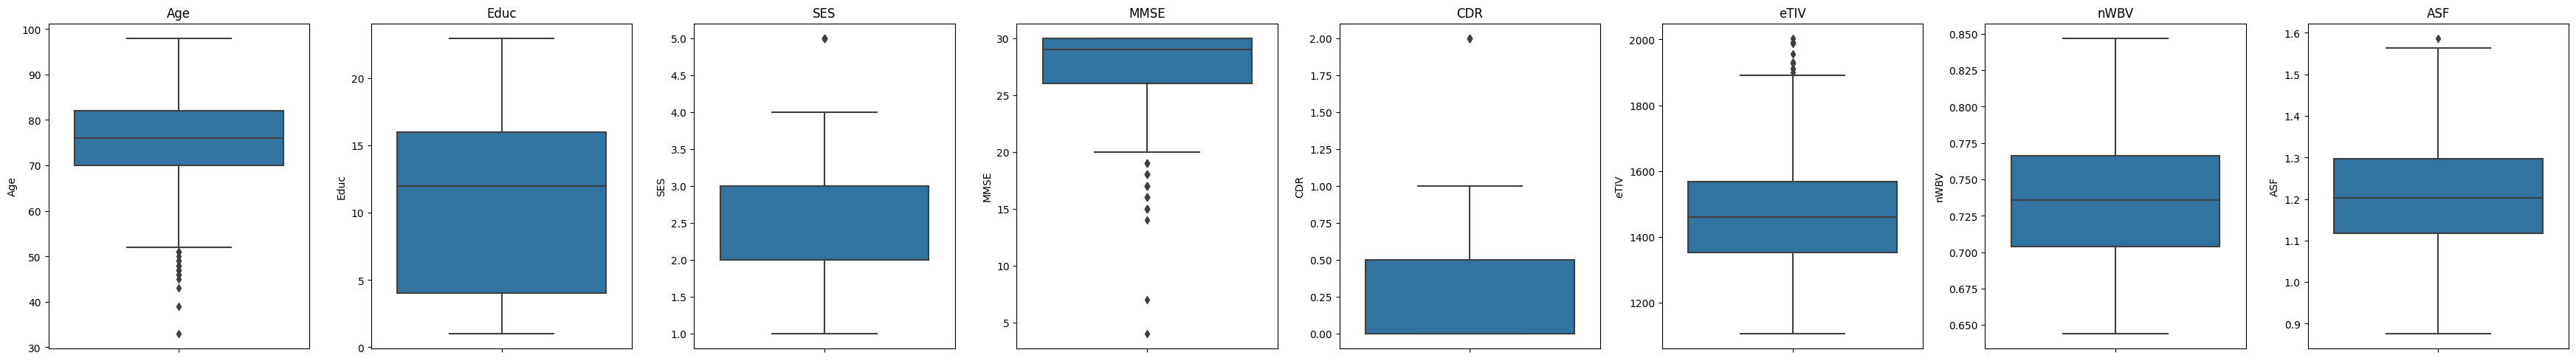

In [212]:
import matplotlib.pyplot as plt
import seaborn as sns
column_names = ['Age','Educ','SES','MMSE','CDR','eTIV','nWBV','ASF']
fig, axes = plt.subplots(nrows=1, ncols=len(column_names), figsize=(35, 5)) # Adjust figsize as needed

for i, col in enumerate(column_names):
    sns.boxplot(y=data[col], ax=axes[i])
    axes[i].set_title(col)  

plt.tight_layout()
plt.show()

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<Axes: >

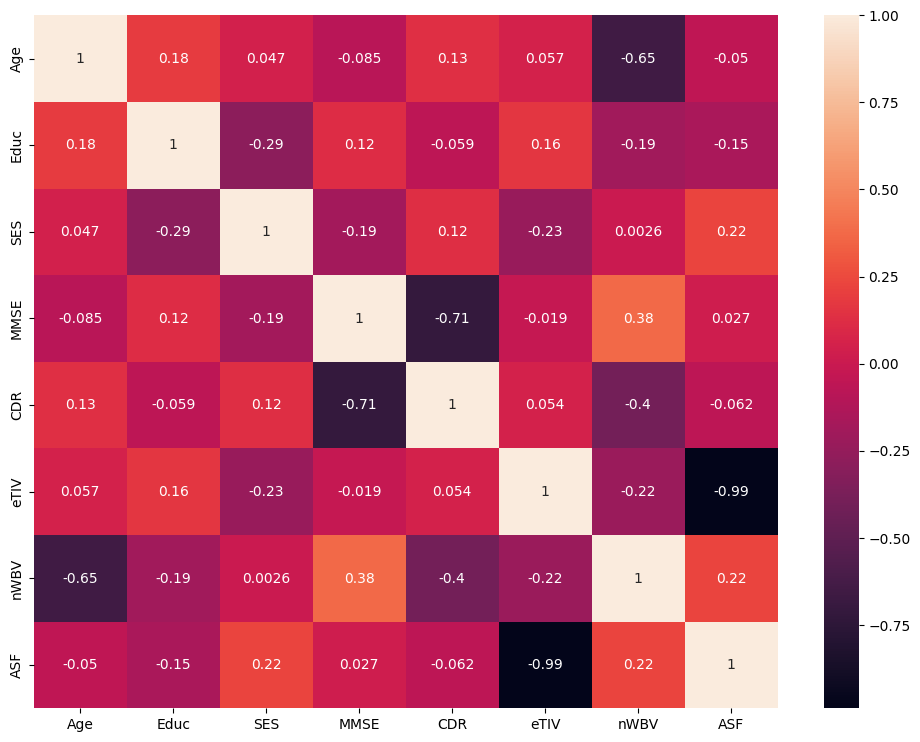

In [213]:
cor = data.corr()
plt.figure(figsize=(12,9))
sns.heatmap(cor, xticklabels=cor.columns.values,yticklabels=cor.columns.values, annot=True)


In [214]:
data.isna().sum()

M/F      0
Hand     0
Age      0
Educ     0
SES     38
MMSE     2
CDR      0
eTIV     0
nWBV     0
ASF      0
dtype: int64

In [215]:
data.dtypes

M/F      object
Hand     object
Age       int64
Educ    float64
SES     float64
MMSE    float64
CDR     float64
eTIV      int64
nWBV    float64
ASF     float64
dtype: object

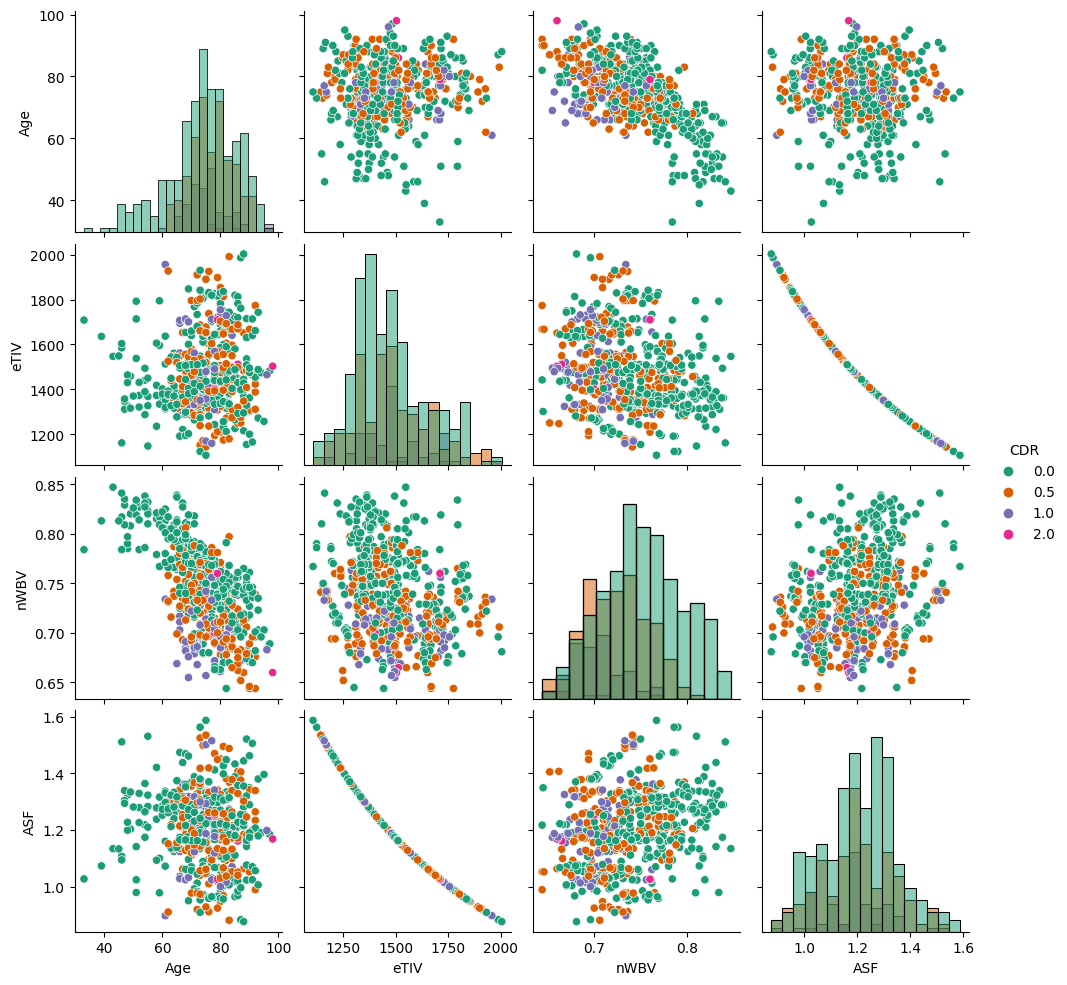

In [216]:
continous_features = ['Age','eTIV','nWBV','ASF','CDR']
custom_palette = ['red','blue','grey','green']
sns.pairplot(data[continous_features], hue='CDR', diag_kind='hist',palette='Dark2')

Lets look at the distributions of each varibles in respect to the target variable 'CDR'.

[Text(0, 0, 'Female'), Text(1, 0, 'Male')]

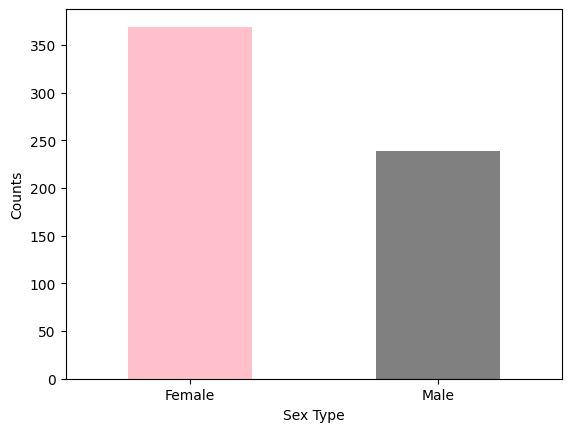

In [217]:
sex_counts = data['M/F'].value_counts()
colors = ['pink', 'grey']
fig,ax = plt.subplots()
ax = sex_counts.plot(kind='bar',xlabel='Sex Type',ylabel='Counts',color=colors)
ax.set_xticklabels(['Female', 'Male'], rotation=0)

Text(0, 0.5, 'Count')

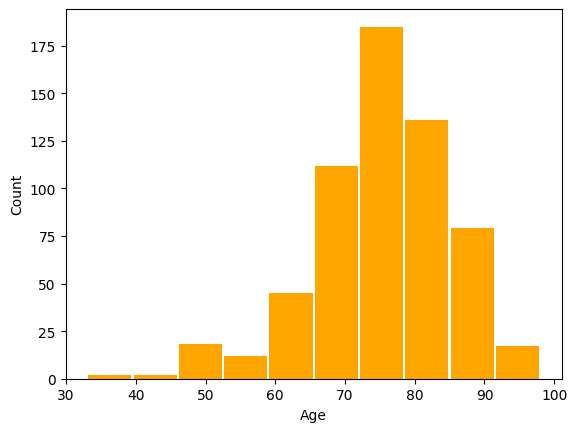

In [218]:
age_counts = data['Age'].value_counts()
fig,ax = plt.subplots()
ax.hist(data['Age'],bins=10,rwidth=0.95,color='orange')
ax.set_xlabel('Age')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

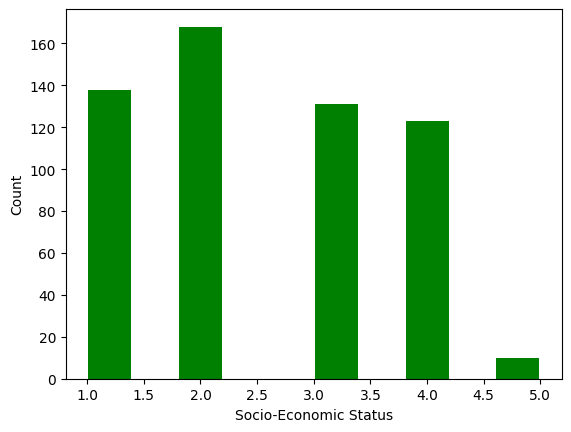

In [219]:
ses_counts = data['SES'].value_counts()
fig,ax = plt.subplots()
ax.hist(data['SES'],bins=10,rwidth=0.95,color='green')
ax.set_xlabel('Socio-Economic Status')
ax.set_ylabel('Count')

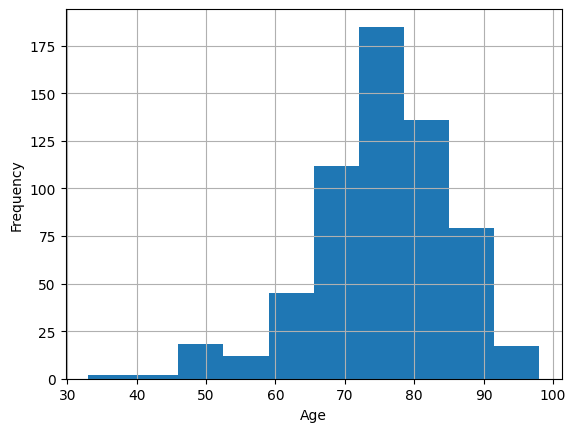

In [220]:
# TODO: write code to plot the distribution of age, race, and sex
# in this code cell

import matplotlib.pyplot as plt
import numpy as np

x = np.random.normal(170, 10, 250)

plt.hist(data["Age"])
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.grid()
plt.show()

## Imputing columns using SimpleImputer.
We fill in the missing values in the "SES" columns with the most occuring data element.
Similarly, we fill the missing values in the "MMSE" column with the median of that column.

In [221]:
from sklearn.impute  import SimpleImputer
imputer = SimpleImputer ( missing_values = np.nan,strategy='most_frequent')

imputer.fit(data[['SES']])
data[['SES']] = imputer.fit_transform(data[['SES']])

# We perform it with the median
imputer = SimpleImputer ( missing_values = np.nan,strategy='median')

imputer.fit(data[['MMSE']])
data[['MMSE']] = imputer.fit_transform(data[['MMSE']])

In [222]:
data

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
8,M,R,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
9,F,R,52,3.0,2.0,30.0,0.0,1321,0.827,1.329
...,...,...,...,...,...,...,...,...,...,...
368,M,R,82,16.0,1.0,28.0,0.5,1693,0.694,1.037
369,M,R,86,16.0,1.0,26.0,0.5,1688,0.675,1.040
370,F,R,61,13.0,2.0,30.0,0.0,1319,0.801,1.331
371,F,R,63,13.0,2.0,30.0,0.0,1327,0.796,1.323


In [223]:
for i, col_type in enumerate(data.dtypes):
    if col_type == "object":
        print("\nVariable {} takes the values: {}".format(
            data.columns[i],
            data[data.columns[i]].unique()))


Variable M/F takes the values: ['F' 'M']

Variable Hand takes the values: ['R']


## Encoding the Target variable using LabelEncoder.

In [224]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data['CDR'] = le.fit_transform(data['CDR'].values)

Converting categorical variables to numeric using OneHot encoding.

In [225]:
categorical_cols = ['M/F','Hand','SES']
data = pd.get_dummies(data,columns=categorical_cols)

In [226]:
data

,Age,Educ,MMSE,CDR,eTIV,nWBV,ASF,M/F_F,M/F_M,Hand_R,SES_1.0,SES_2.0,SES_3.0,SES_4.0,SES_5.0
0,74,2.0,29.0,0,1344,0.743,1.306,1,0,1,0,0,1,0,0
1,55,4.0,29.0,0,1147,0.810,1.531,1,0,1,1,0,0,0,0
2,73,4.0,27.0,1,1454,0.708,1.207,1,0,1,0,0,1,0,0
8,74,5.0,30.0,0,1636,0.689,1.073,0,1,1,0,1,0,0,0
9,52,3.0,30.0,0,1321,0.827,1.329,1,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,82,16.0,28.0,1,1693,0.694,1.037,0,1,1,1,0,0,0,0
369,86,16.0,26.0,1,1688,0.675,1.040,0,1,1,1,0,0,0,0
370,61,13.0,30.0,0,1319,0.801,1.331,1,0,1,0,1,0,0,0
371,63,13.0,30.0,0,1327,0.796,1.323,1,0,1,0,1,0,0,0


In [227]:
data.drop(columns=['M/F_F'], inplace=True)
data.rename(columns={'M/F_M':'M/F'}, inplace=True)

data.head()

,Age,Educ,MMSE,CDR,eTIV,nWBV,ASF,M/F,Hand_R,SES_1.0,SES_2.0,SES_3.0,SES_4.0,SES_5.0
0,74,2.0,29.0,0,1344,0.743,1.306,0,1,0,0,1,0,0
1,55,4.0,29.0,0,1147,0.810,1.531,0,1,1,0,0,0,0
2,73,4.0,27.0,1,1454,0.708,1.207,0,1,0,0,1,0,0
8,74,5.0,30.0,0,1636,0.689,1.073,1,1,0,1,0,0,0
9,52,3.0,30.0,0,1321,0.827,1.329,0,1,0,1,0,0,0


## Plotting the distribution of classes on a barplot.

<BarContainer object of 4 artists>

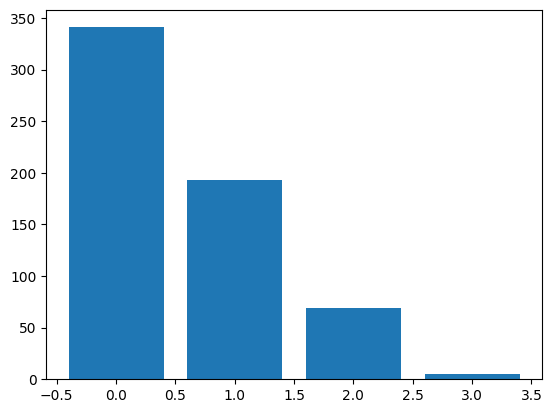

In [228]:
plt.bar(data['CDR'].unique(),data['CDR'].value_counts())

Neglecting the last class due to negligible size in the combined dataset.

In [229]:
data = data.drop(data[data['CDR']==3].index)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 599 entries, 0 to 372
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Age      599 non-null    int64  
 1   Educ     599 non-null    float64
 2   MMSE     599 non-null    float64
 3   CDR      599 non-null    int64  
 4   eTIV     599 non-null    int64  
 5   nWBV     599 non-null    float64
 6   ASF      599 non-null    float64
 7   M/F      599 non-null    uint8  
 8   Hand_R   599 non-null    uint8  
 9   SES_1.0  599 non-null    uint8  
 10  SES_2.0  599 non-null    uint8  
 11  SES_3.0  599 non-null    uint8  
 12  SES_4.0  599 non-null    uint8  
 13  SES_5.0  599 non-null    uint8  
dtypes: float64(4), int64(3), uint8(7)
memory usage: 41.5 KB


In [230]:
y = data.pop('CDR')
x = data

#Checking the baseline accuracy 

<Axes: >

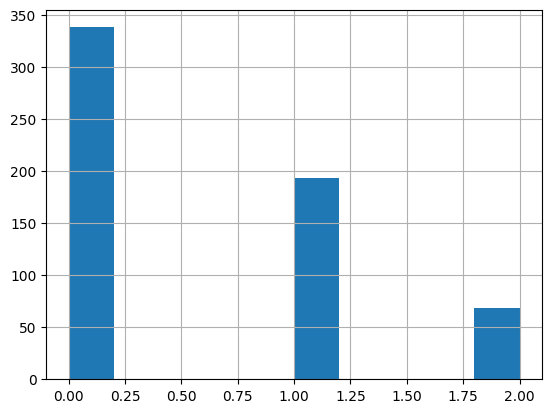

In [231]:
y.hist()

In [232]:
class_counts = y.value_counts()
class_counts 

0    338
1    193
2     68
Name: CDR, dtype: int64

#Baseline Accuracy = 338/599 = 57%

This is because class 0 is the Majority Class and has 338 instances. 

In [233]:
feature_names = data.columns
feature_names

Index(['Age', 'Educ', 'MMSE', 'eTIV', 'nWBV', 'ASF', 'M/F', 'Hand_R',
       'SES_1.0', 'SES_2.0', 'SES_3.0', 'SES_4.0', 'SES_5.0'],
      dtype='object')

In [234]:
numerical_features = ['MMSE','eTIV','nWBV','ASF']

## Normalizing the data.
We observe that different columns have different ranges of values. We use Z-score normalization in this case.

In [235]:
x[numerical_features] = StandardScaler().fit_transform(x[numerical_features])
x

,Age,Educ,MMSE,eTIV,nWBV,ASF,M/F,Hand_R,SES_1.0,SES_2.0,SES_3.0,SES_4.0,SES_5.0
0,74,2.0,0.469289,-0.773079,0.127175,0.750342,0,1,0,0,1,0,0
1,55,4.0,0.469289,-1.923132,1.710276,2.409662,0,1,1,0,0,0,0
2,73,4.0,-0.090679,-0.130918,-0.699818,0.020241,0,1,0,0,1,0,0
8,74,5.0,0.749273,0.931568,-1.148757,-0.967977,1,1,0,1,0,0,0
9,52,3.0,0.749273,-0.907349,2.111959,0.919961,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,82,16.0,0.189305,1.264325,-1.030615,-1.233468,1,1,1,0,0,0,0
369,86,16.0,-0.370664,1.235135,-1.479555,-1.211344,1,1,1,0,0,0,0
370,61,13.0,0.749273,-0.919025,1.497621,0.934711,0,1,0,1,0,0,0
371,63,13.0,0.749273,-0.872322,1.379479,0.875713,0,1,0,1,0,0,0


## Dividing dataset into train and test sets.

In [236]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 42,test_size=0.3)

In [237]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (419, 13)
X_test shape: (180, 13)
y_train shape: (419,)
y_test shape: (180,)


## Defining Models.



```
# This is formatted as code
```

### 1. We will try hyperparameter tuning using cross-validation for XGBClassifier.

In [238]:
from xgboost import XGBClassifier
FOLDS = 5

parametros_xgb = {
    "learning_rate": [0.01, 0.025, 0.005,0.5, 0.075, 0.1, 0.15, 0.2,0.3,0.8,0.9],
    "max_depth":[3,5,8,10,15,20,25,30,40,50],
    "n_estimators":range(1,1000)
    }

model_xgb= XGBClassifier(eval_metric='mlogloss')


xgb_random = RandomizedSearchCV(estimator = model_xgb, param_distributions = parametros_xgb, n_iter = 100, cv = FOLDS, 
                               verbose=0, random_state=42,n_jobs = -1, scoring='accuracy')
xgb_random.fit(X_train, y_train)

xgb_random.best_params_

{'n_estimators': 583, 'max_depth': 5, 'learning_rate': 0.5}

In [239]:
model_xgb = xgb_random.best_estimator_
model_xgb.fit(X_train,y_train)
model_xgb.score(X_test,y_test)

0.7666666666666667

### 2. Trying hyperparameter tuning of GradientBoostingClassifier.

In [240]:
from sklearn.ensemble import GradientBoostingClassifier
FOLDS =10

parametros_gb = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.005,0.5, 0.075, 0.1, 0.15, 0.2,0.3,0.8,0.9],
    "min_samples_split": [0.01, 0.025, 0.005,0.4,0.5, 0.075, 0.1, 0.15, 0.2,0.3,0.8,0.9],
    "min_samples_leaf": [1,2,3,5,8,10,15,20,40,50,55,60,65,70,80,85,90,100],
    "max_depth":[3,5,8,10,15,20,25,30,40,50],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "squared_error"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":range(1,100)
    }

model_gb= GradientBoostingClassifier()


gb_random = RandomizedSearchCV(estimator = model_gb, param_distributions = parametros_gb, n_iter = 100, cv = FOLDS, 
                               verbose=0, random_state=42,n_jobs = -1, scoring='accuracy')
gb_random.fit(X_train, y_train)

gb_random.best_params_

The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.


{'subsample': 1.0,
 'n_estimators': 23,
 'min_samples_split': 0.025,
 'min_samples_leaf': 10,
 'max_features': 'log2',
 'max_depth': 10,
 'loss': 'deviance',
 'learning_rate': 0.8,
 'criterion': 'squared_error'}

In [241]:
model_gb = gb_random.best_estimator_
print(model_gb.score(X_test,y_test))

0.7611111111111111


GradientBoosting model performs better than XGboost, Hence we try 10-fold cross validation on GradientBoostingClassifier model to improve accuracy.

In [242]:
cross_val_score(model_gb, x, y, cv=10, scoring='accuracy').mean()

The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in v

0.777909604519774

### Making predictions using the best estimator and plotting the confusion matrix along with classification report.

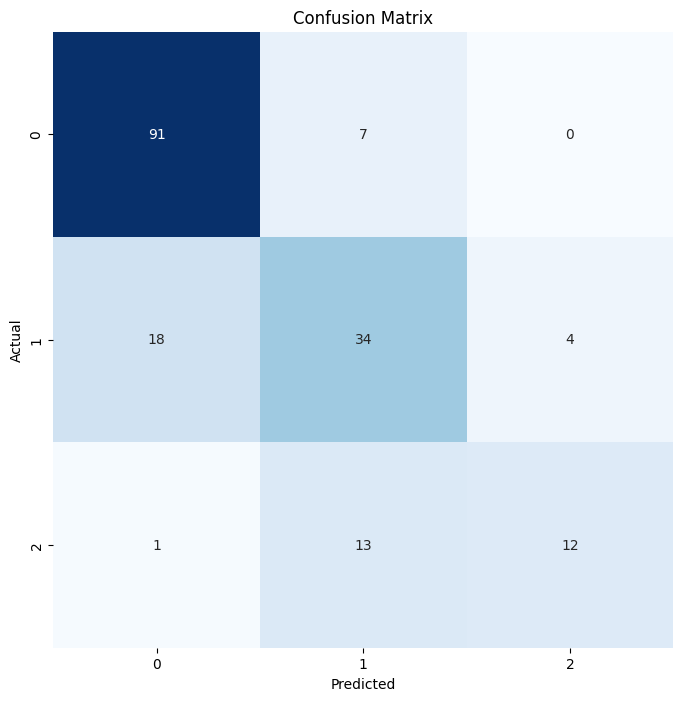

Classification Report:
----------------------
               precision    recall  f1-score   support

           0       0.83      0.93      0.87        98
           1       0.63      0.61      0.62        56
           2       0.75      0.46      0.57        26

    accuracy                           0.76       180
   macro avg       0.74      0.67      0.69       180
weighted avg       0.75      0.76      0.75       180



In [243]:
y_pred = model_gb.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
clr = classification_report(y_test, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)


#1. Using Fairlearn we see fairness :

Here we will be using fairlearn to analyse the fairness of our classifier on the test set. Initially we will be focusing on 2 metric - demographic parity difference and demographic parity ratio.

Next we will use also calculate metrics like accuracy and recall on our data and compare these metrics for all sensitive features and their respective groups. 

First we will work on analyzing our test set on the feature 'SEX' ( MALE OR FEMALE ).

In [244]:
#@markdown Evaluate the fairness of the classifier using `demographic_parity_difference` and `demographic_parity_ratio`
#note: we are conducting this analysis over the test set

#compute demographic parity difference and demographic parity ratio
demo_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=X_test['M/F'])
demo_parity_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=X_test['M/F'])

print(f'Demographic parity difference: {demo_parity_diff:.4f}')
print(f'Demographic parity ratio: {demo_parity_ratio:.4f}')

Demographic parity difference: 0.1169
Demographic parity ratio: 0.6853


In [245]:
from sklearn.metrics import accuracy_score, recall_score

sensitive_feature_sex = X_test['M/F'].replace({0:'female', 1:'male'})
mf = MetricFrame(metrics={'accuracy': accuracy_score, 'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro')},
                 y_true=y_test,
                 y_pred=y_pred,
                 sensitive_features=sensitive_feature_sex)

In [246]:
mf.overall

accuracy    0.761111
recall      0.665751
dtype: float64

We can see that the overall accuracy is 0.822 while the recall is 0.7278. Next we will see the accuracy and recall per group ( male and female )

In [247]:
mf.by_group

,accuracy,recall
M/F,,
female,0.818182,0.640363
male,0.671429,0.695365


We see that the accuracy of prediction of dementia are better for females than males. 

Accuracy

1.   Females : 0.873
2.   Males 0.743

Recall

1.   Females : 0.717
2.   Males 0.751


We can confirm that their is a certain bias when it comes to the model where it is more accurately predicting dementia results for females than males.

In case of recall results we can see that the model shows high recall for males than females which suggests that the model is good at correctly identifying positive cases (in this case, dementia) among males. This means that it catches a high proportion of males who truly have dementia, which is a positive aspect. 

<Axes: title={'center': 'Accuracy and selection rate by sex'}, xlabel='M/F'>

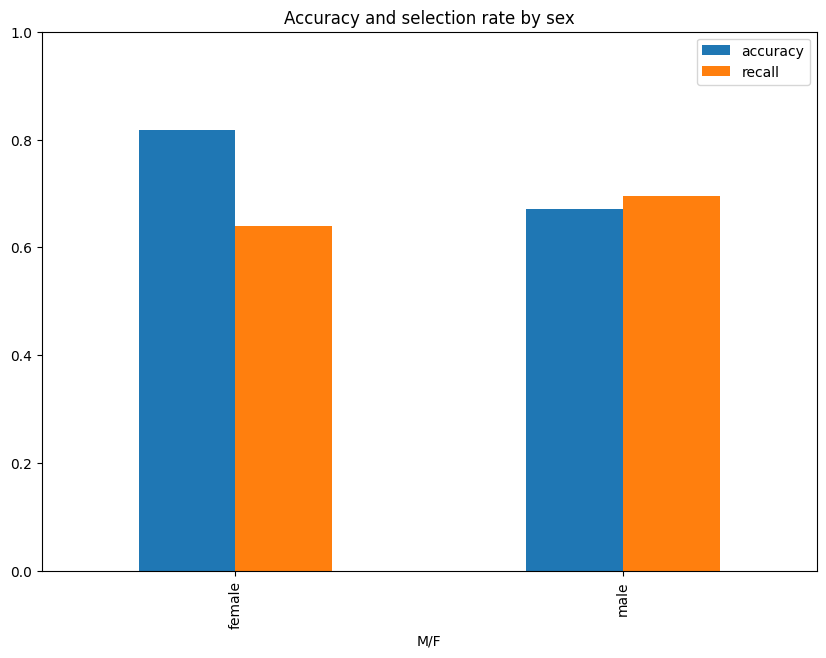

In [248]:
metrics_1 = {'accuracy': accuracy_score, 'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro')}

grouped_on_sex_accuracy = MetricFrame(metrics=metrics_1,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_sex)


grouped_on_sex_accuracy.by_group.plot.bar(
    subplots=False, 
    figsize=(10, 7), 
    ylim=[0,1],
    title="Accuracy and selection rate by sex",
    )

In [249]:
X_test['Age'] = X_test['Age'].astype(float)

In [250]:
bins = [0, 70, 80, 90, 96]  # Define your own age ranges
labels = ['0','1', '2', '3']  # Labels for the age ranges
X_test['age_group'] = pd.cut(X_test['Age'], bins=bins, labels=labels)

sensitive_feature_age = X_test['age_group']

In [251]:
sensitive_feature_age = sensitive_feature_age.astype(float)
sensitive_feature_age

201    3.0
189    1.0
338    1.0
145    2.0
323    0.0
      ... 
98     2.0
264    2.0
77     1.0
172    0.0
33     2.0
Name: age_group, Length: 180, dtype: float64

In [252]:
X_test

,Age,Educ,MMSE,eTIV,nWBV,ASF,M/F,Hand_R,SES_1.0,SES_2.0,SES_3.0,SES_4.0,SES_5.0,age_group
201,94.0,5.0,0.469289,-0.014161,-0.983359,-0.105130,0,1,1,0,0,0,0,3
189,73.0,18.0,0.469289,0.417839,0.836026,-0.518117,1,1,0,1,0,0,0,1
338,75.0,16.0,0.749273,2.420216,-0.676190,-2.037317,1,1,1,0,0,0,0,1
145,86.0,4.0,0.749273,-1.070809,0.434344,1.126454,0,1,0,0,1,0,0,2
323,55.0,4.0,0.749273,-0.154269,1.946560,0.042365,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,81.0,2.0,0.749273,-1.438592,-0.487163,1.642687,0,1,0,0,0,1,0,2
264,84.0,18.0,0.469289,1.118379,-1.030615,-1.122847,1,1,1,0,0,0,0,2
77,75.0,2.0,0.189305,-0.405296,0.906912,0.315231,0,1,0,0,1,0,0,1
172,48.0,4.0,0.749273,-0.072539,1.237709,-0.038757,1,1,0,1,0,0,0,0


In [253]:
mf = MetricFrame(metrics={'accuracy': accuracy_score, 'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro')},
                y_true=y_test,
                 y_pred=y_pred,
                 sensitive_features=sensitive_feature_age)

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [254]:
mf.overall

accuracy    0.761111
recall      0.665751
dtype: float64

In [255]:
mf.by_group

,accuracy,recall
age_group,,
0.0,0.860465,0.708333
1.0,0.682927,0.641758
2.0,0.800000,0.661111
3.0,0.777778,0.333333


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


<Axes: title={'center': 'Accuracy and selection rate by age'}, xlabel='age_group'>

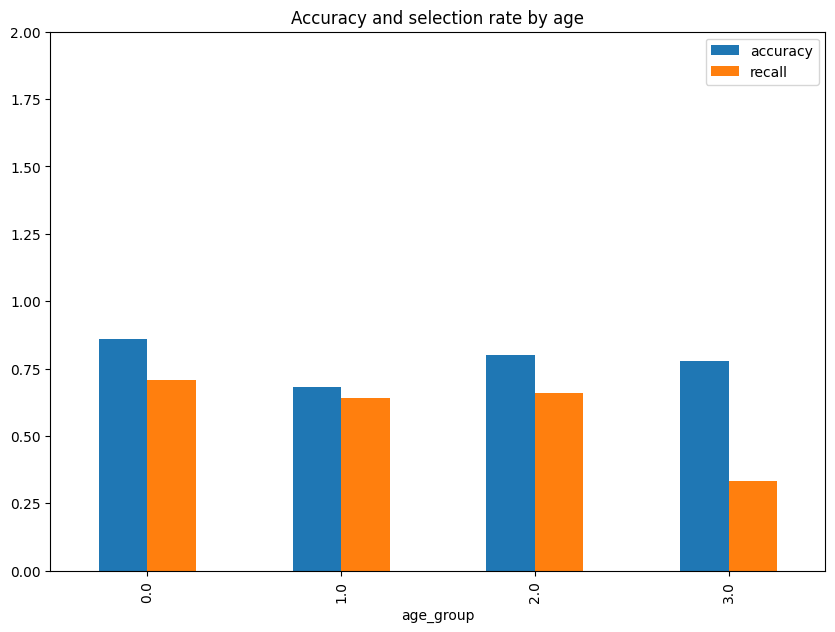

In [256]:
metrics_1 = {'accuracy': accuracy_score, 'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro')}

grouped_on_age_accuracy = MetricFrame(metrics=metrics_1,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_age)

#grouped_on_age_accuracy.index = ['<60', '60-70', '70-80', '80-90', '>90'] 

grouped_on_age_accuracy.by_group.plot.bar(
    subplots=False, 
    figsize=(10, 7), 
    ylim=[0,2],
    title="Accuracy and selection rate by age",
    )

In [257]:
df_one_hot = X_test[['SES_1.0', 'SES_2.0', 'SES_3.0', 'SES_4.0', 'SES_5.0']]

X_test['SES'] = df_one_hot.idxmax(axis=1)
X_test['SES'] = X_test['SES'].replace({'SES_1.0': 1, 'SES_2.0': 2, 'SES_3.0': 3, 'SES_4.0': 4, 'SES_5.0': 5})
sensitive_feature_education = X_test['SES']

In [258]:
mf = MetricFrame(metrics={'accuracy': accuracy_score, 'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro')},
                y_true=y_test,
                 y_pred=y_pred,
                 sensitive_features=sensitive_feature_education)

mf.overall

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


accuracy    0.761111
recall      0.665751
dtype: float64

In [259]:
mf.by_group

,accuracy,recall
SES,,
1,0.787234,0.695988
2,0.786885,0.659524
3,0.694444,0.555556
4,0.757576,0.790476
5,0.666667,0.500000


#2. Using Aequitas we check fairness !!!!

In [1]:
metrics_1 = {'accuracy': accuracy_score, 'recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro')}

grouped_on_education_accuracy = MetricFrame(metrics=metrics_1,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_education)

#grouped_on_age_accuracy.index = ['<60', '60-70', '70-80', '80-90', '>90'] 

grouped_on_education_accuracy.by_group.plot.bar(
    subplots=False, 
    figsize=(10, 7), 
    ylim=[0,2],
    title="Accuracy and recall by Social economic status",
    )

NameError: ignored

In [261]:
X_test

,Age,Educ,MMSE,eTIV,nWBV,ASF,M/F,Hand_R,SES_1.0,SES_2.0,SES_3.0,SES_4.0,SES_5.0,age_group,SES
201,94.0,5.0,0.469289,-0.014161,-0.983359,-0.105130,0,1,1,0,0,0,0,3,1
189,73.0,18.0,0.469289,0.417839,0.836026,-0.518117,1,1,0,1,0,0,0,1,2
338,75.0,16.0,0.749273,2.420216,-0.676190,-2.037317,1,1,1,0,0,0,0,1,1
145,86.0,4.0,0.749273,-1.070809,0.434344,1.126454,0,1,0,0,1,0,0,2,3
323,55.0,4.0,0.749273,-0.154269,1.946560,0.042365,0,1,0,0,1,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,81.0,2.0,0.749273,-1.438592,-0.487163,1.642687,0,1,0,0,0,1,0,2,4
264,84.0,18.0,0.469289,1.118379,-1.030615,-1.122847,1,1,1,0,0,0,0,2,1
77,75.0,2.0,0.189305,-0.405296,0.906912,0.315231,0,1,0,0,1,0,0,1,3
172,48.0,4.0,0.749273,-0.072539,1.237709,-0.038757,1,1,0,1,0,0,0,0,2


In [262]:
#@title

# we have computed y_pred before so will use it.

# Build the of information to pass to Aequitas
pred_data = X_test.filter(items=["SES","Age","M/F",'Educ'])
pred_data['sex_name'] = pred_data['M/F'].replace({0:'female',1:'male'})
pred_data['score'] = y_pred
pred_data['label_value'] = y_test
# Score and label_value are boolean by default, and we need them to be int
pred_data['score'] = pred_data['score'].astype('int')
pred_data['label_value'] = pred_data['label_value'].astype('int')
pred_data = pred_data.drop('M/F',axis=1)
pred_data.head()

,SES,Age,Educ,sex_name,score,label_value
201,1,94.0,5.0,female,0,0
189,2,73.0,18.0,male,0,0
338,1,75.0,16.0,male,0,1
145,3,86.0,4.0,female,0,0
323,3,55.0,4.0,female,0,0


In [263]:
aq_palette = sns.color_palette(["#0091D5", "#F25F5C", "#43A047"])

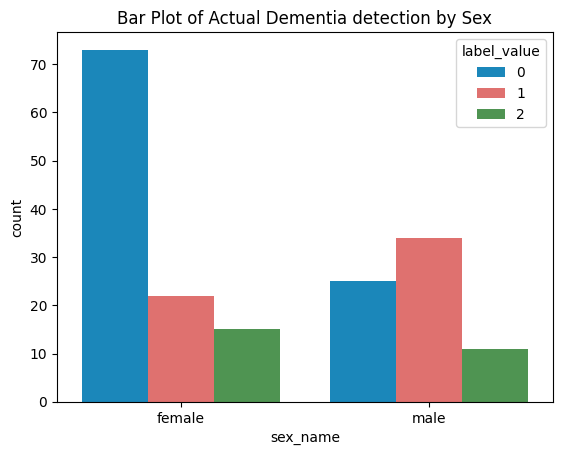

In [264]:
#@title
label_by_race = sns.countplot(x="sex_name", hue="label_value", data=pred_data, palette=aq_palette)
plt.title("Bar Plot of Actual Dementia detection by Sex");

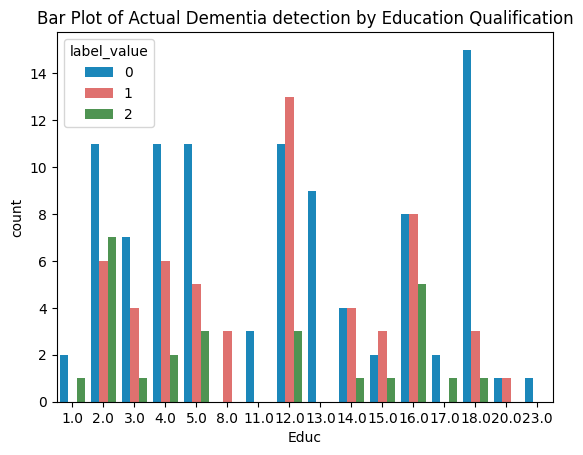

In [265]:
#@title
label_by_race = sns.countplot(x="Educ", hue="label_value", data=pred_data, palette=aq_palette)
plt.title("Bar Plot of Actual Dementia detection by Education Qualification");

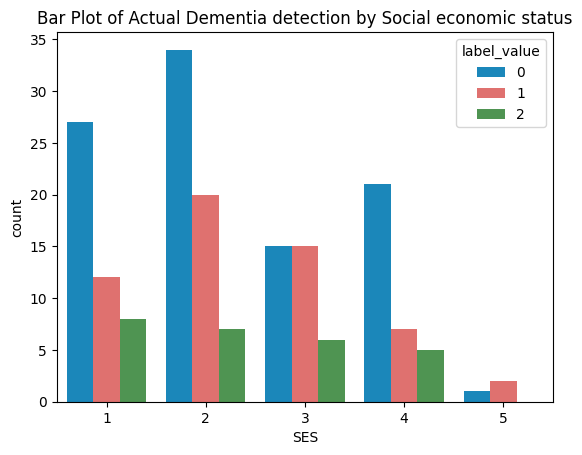

In [266]:
#@title
label_by_race = sns.countplot(x="SES", hue="label_value", data=pred_data, palette=aq_palette)
plt.title("Bar Plot of Actual Dementia detection by Social economic status");

In [267]:
pred_data.head()

,SES,Age,Educ,sex_name,score,label_value
201,1,94.0,5.0,female,0,0
189,2,73.0,18.0,male,0,0
338,1,75.0,16.0,male,0,1
145,3,86.0,4.0,female,0,0
323,3,55.0,4.0,female,0,0


Now to use SES attribute for our analysis using aequitas we will rename the values in the dataset to string values using the below format:


SES values:

*   1 : Very Low
*   2 : Low
*   3 : Medium
*   4 : High
*   5 : Very High



In [268]:
pred_data['SES'] = pred_data['SES'].replace({1:'very low',2:'low',3:'medium',4:'high',5:'very high'})

In [269]:
pred_data['SES'] = pred_data['SES'].astype('str')
pred_data = pred_data.rename(columns={'sex_name':'sex','SES':'social_status'})
pred_data['sex_social_status'] = pred_data['sex'] + ' ' + pred_data['social_status']
pred_data.head()

,social_status,Age,Educ,sex,score,label_value,sex_social_status
201,very low,94.0,5.0,female,0,0,female very low
189,low,73.0,18.0,male,0,0,male low
338,very low,75.0,16.0,male,0,1,male very low
145,medium,86.0,4.0,female,0,0,female medium
323,medium,55.0,4.0,female,0,0,female medium


In [270]:
pred_data = pred_data.drop(['Age','Educ'],axis=1)

In [271]:
pred_data.head()

,social_status,sex,score,label_value,sex_social_status
201,very low,female,0,0,female very low
189,low,male,0,0,male low
338,very low,male,0,1,male very low
145,medium,female,0,0,female medium
323,medium,female,0,0,female medium


In [272]:
g = Group()
xtab, _ = g.get_crosstabs(pred_data,attr_cols=['sex_social_status','sex','social_status'])

In [273]:
absolute_metrics = g.list_absolute_metrics(xtab)
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,54,sex_social_status,female high,2,14,2,2,12,0,2,14,19,180
1,0,binary 0/1,54,sex_social_status,female low,3,30,0,3,27,3,6,27,39,180
2,0,binary 0/1,54,sex_social_status,female medium,7,19,0,5,14,7,12,14,30,180
3,0,binary 0/1,54,sex_social_status,female very high,1,2,0,1,1,1,2,1,3,180
4,0,binary 0/1,54,sex_social_status,female very low,0,17,0,0,17,0,0,17,19,180
5,0,binary 0/1,54,sex_social_status,male high,7,5,4,2,3,3,5,7,14,180
6,0,binary 0/1,54,sex_social_status,male low,7,14,0,7,7,7,14,7,22,180
7,0,binary 0/1,54,sex_social_status,male medium,2,2,0,1,1,2,3,1,6,180
8,0,binary 0/1,54,sex_social_status,male very low,4,18,0,8,10,4,12,10,28,180
9,0,binary 0/1,54,sex,female,13,82,2,11,71,11,22,73,110,180


In [274]:
#@markdown View calculated "absolute metrics" (like false positive rates) for each group
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,sex_social_status,female high,0.00,0.86,0.14,1.00,0.14,1.00,0.86,0.00,0.04,0.12,0.11
1,sex_social_status,female low,0.50,1.00,0.10,0.00,0.00,0.50,0.90,1.00,0.06,0.09,0.15
2,sex_social_status,female medium,0.58,1.00,0.26,0.00,0.00,0.42,0.74,1.00,0.13,0.27,0.40
3,sex_social_status,female very high,0.50,1.00,0.50,0.00,0.00,0.50,0.50,1.00,0.02,0.33,0.67
4,sex_social_status,female very low,NaN,1.00,0.00,NaN,0.00,NaN,1.00,NaN,0.00,0.00,0.00
5,sex_social_status,male high,0.60,0.43,0.40,0.57,0.57,0.40,0.60,0.43,0.13,0.58,0.36
6,sex_social_status,male low,0.50,1.00,0.50,0.00,0.00,0.50,0.50,1.00,0.13,0.33,0.64
7,sex_social_status,male medium,0.67,1.00,0.50,0.00,0.00,0.33,0.50,1.00,0.04,0.50,0.50
8,sex_social_status,male very low,0.33,1.00,0.44,0.00,0.00,0.67,0.56,1.00,0.07,0.18,0.43
9,sex,female,0.50,0.97,0.13,0.15,0.03,0.50,0.87,0.85,0.24,0.14,0.20


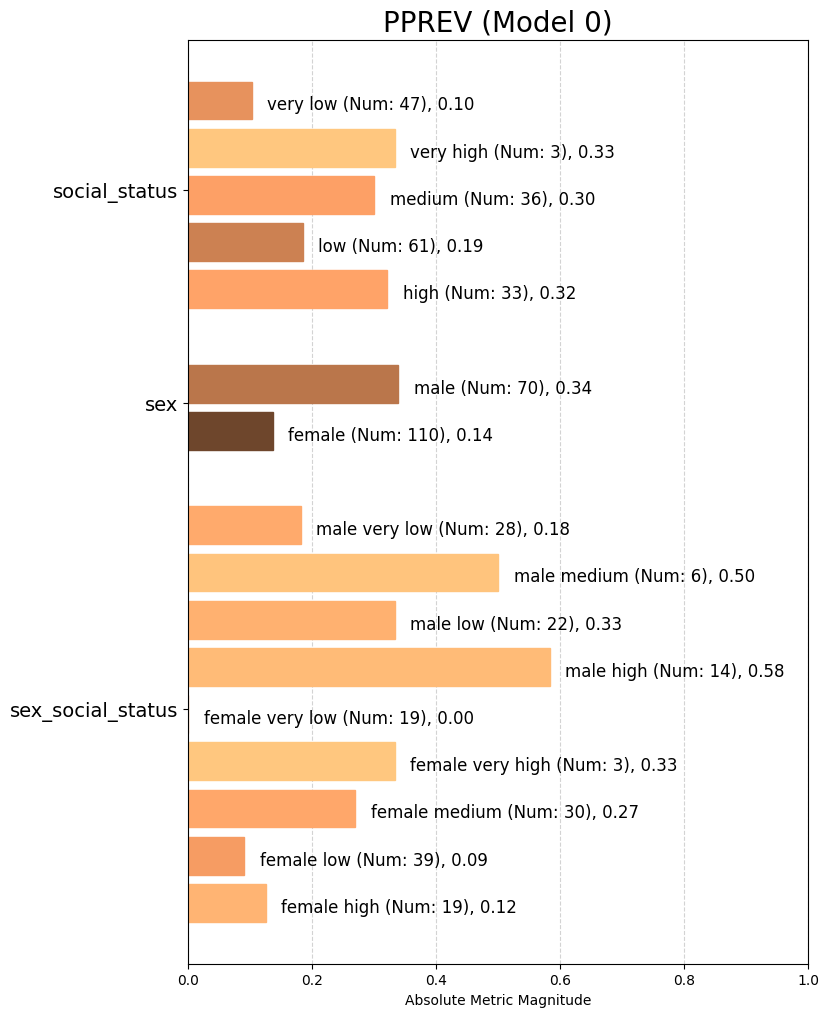

In [275]:
aqp = Plot()
fnr = aqp.plot_group_metric(xtab, 'pprev')
fig = plt.gcf()
fig.set_size_inches(8,12)

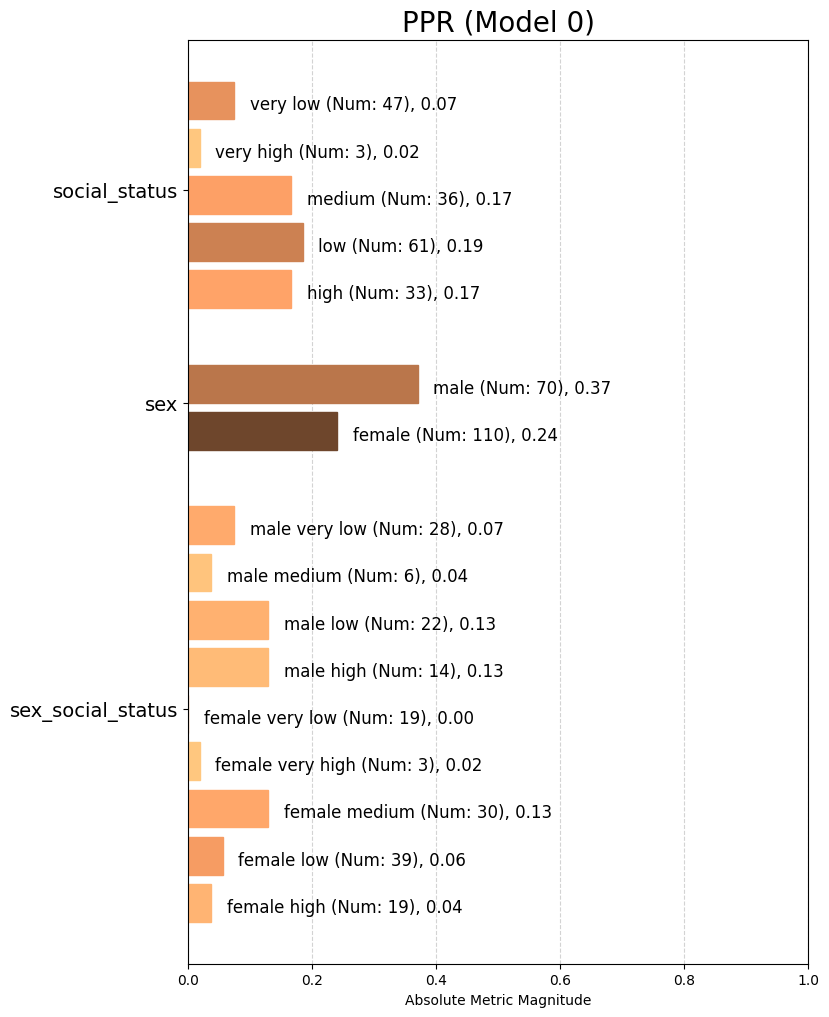

In [276]:
aqp = Plot()
fnr = aqp.plot_group_metric(xtab, 'ppr')
fig = plt.gcf()
fig.set_size_inches(8,12)

In [277]:
b = Bias()
bdf = b.get_disparity_predefined_groups(xtab, original_df=pred_data, ref_groups_dict={'sex':'male', 'social_status':'high', 'sex_social_status': 'male high'}, alpha=0.05, mask_significance=True)

get_disparity_predefined_group()


In [278]:
#@title
calculated_disparities = b.list_disparities(bdf)
bdf[['attribute_name', 'attribute_value'] +  ['fpr_disparity', 'pprev_disparity', 'fdr_disparity']]

,attribute_name,attribute_value,fpr_disparity,pprev_disparity,fdr_disparity
0,sex_social_status,female high,0.250000,0.214286,1.750000
1,sex_social_status,female low,0.000000,0.155844,0.000000
2,sex_social_status,female medium,0.000000,0.461538,0.000000
3,sex_social_status,female very high,0.000000,0.571429,0.000000
4,sex_social_status,female very low,0.000000,0.000000,NaN
5,sex_social_status,male high,1.000000,1.000000,1.000000
6,sex_social_status,male low,0.000000,0.571429,0.000000
7,sex_social_status,male medium,0.000000,0.857143,0.000000
8,sex_social_status,male very low,0.000000,0.311688,0.000000
9,sex,female,0.171233,0.403684,0.769231


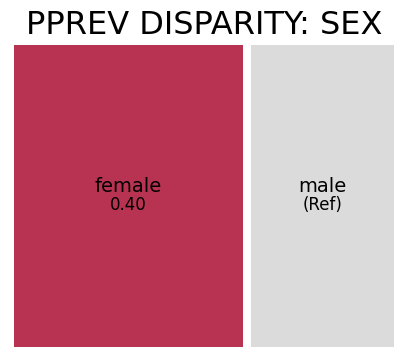

In [279]:
#@title
f = Fairness()
fdf = f.get_group_value_fairness(bdf)
parity_detrminations = f.list_parities(fdf)
fdf[['attribute_name', 'attribute_value'] + absolute_metrics + calculated_disparities + parity_detrminations].style
m = aqp.plot_fairness_disparity(fdf, group_metric='pprev', attribute_name='sex')

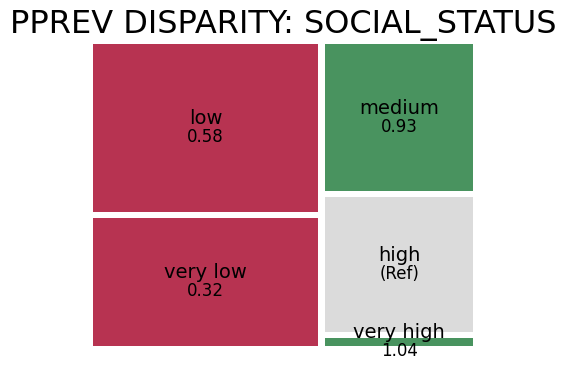

In [280]:
f = Fairness()
fdf = f.get_group_value_fairness(bdf)
parity_detrminations = f.list_parities(fdf)
fdf[['attribute_name', 'attribute_value'] + absolute_metrics + calculated_disparities + parity_detrminations].style
m = aqp.plot_fairness_disparity(fdf, group_metric='pprev', attribute_name='social_status')

#ML-INSPECT ANALYSIS 

In [281]:
!apt install libgraphviz-dev
!pip install pygraphviz
!pip install mlinspect
!pip install tensorflow==2.5.0
!pip install keras==2.4.3
!pip install jinja2==3.0.3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.42.2-3build2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached mlinspect-0.0.1.dev0-py3-none-any.whl (90 kB)
  Using cached scikit-learn-0.23.2.tar.gz (7.2 MB)
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error orig

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#SHAP ANALYSIS

In [282]:
!pip install shap==0.39.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [283]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import shap
from IPython.display import Image
from IPython.core.display import HTML 
import operator
from collections import defaultdict
shap.initjs()
import xgboost

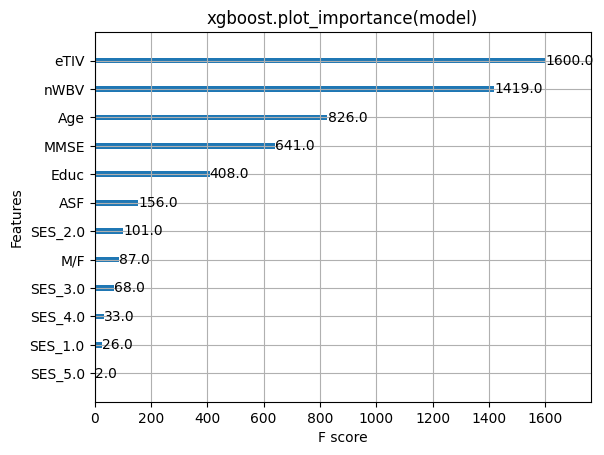

In [284]:
xgboost.plot_importance(model_xgb)
plt.title("xgboost.plot_importance(model)")
plt.show()

In [285]:
X_test

,Age,Educ,MMSE,eTIV,nWBV,ASF,M/F,Hand_R,SES_1.0,SES_2.0,SES_3.0,SES_4.0,SES_5.0,age_group,SES
201,94.0,5.0,0.469289,-0.014161,-0.983359,-0.105130,0,1,1,0,0,0,0,3,1
189,73.0,18.0,0.469289,0.417839,0.836026,-0.518117,1,1,0,1,0,0,0,1,2
338,75.0,16.0,0.749273,2.420216,-0.676190,-2.037317,1,1,1,0,0,0,0,1,1
145,86.0,4.0,0.749273,-1.070809,0.434344,1.126454,0,1,0,0,1,0,0,2,3
323,55.0,4.0,0.749273,-0.154269,1.946560,0.042365,0,1,0,0,1,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,81.0,2.0,0.749273,-1.438592,-0.487163,1.642687,0,1,0,0,0,1,0,2,4
264,84.0,18.0,0.469289,1.118379,-1.030615,-1.122847,1,1,1,0,0,0,0,2,1
77,75.0,2.0,0.189305,-0.405296,0.906912,0.315231,0,1,0,0,1,0,0,1,3
172,48.0,4.0,0.749273,-0.072539,1.237709,-0.038757,1,1,0,1,0,0,0,0,2


In [196]:
X_test_shap = X_test.drop(['age_group','SES'],axis=1)
class_names = ["CDR : 0", "CDR : 0.5", "CDR : 1"]
explainer = shap.LinearExplainer(model_xgb, X_test_shap)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test_shap,class_names =class_names)

Exception: ignored

In [ ]:
background_data = shap.maskers.Independent(X_train)

In [ ]:
#pip install --upgrade shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached shap-0.41.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (572 kB)
  Attempting uninstall: shap
    Found existing installation: shap 0.39.0
    Uninstalling shap-0.39.0:
      Successfully uninstalled shap-0.39.0


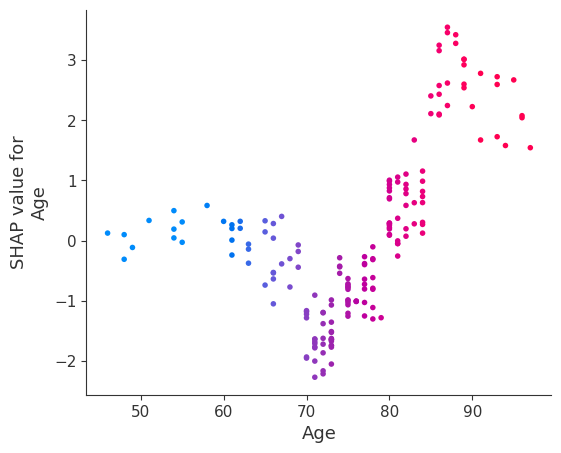

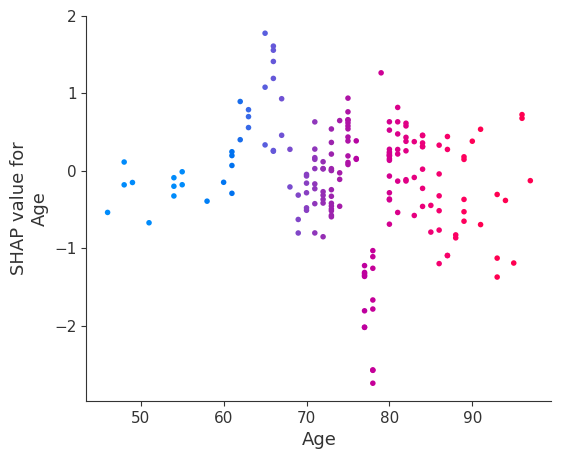

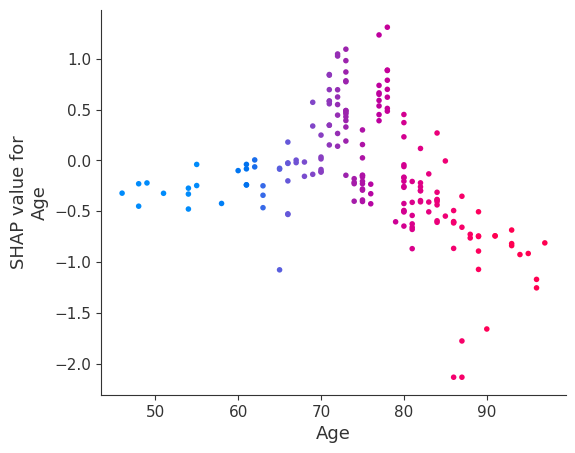

In [ ]:
for i in range(len(shap_values)):
  shap.dependence_plot('Age', shap_values[i], X_test_shap, interaction_index='Age')

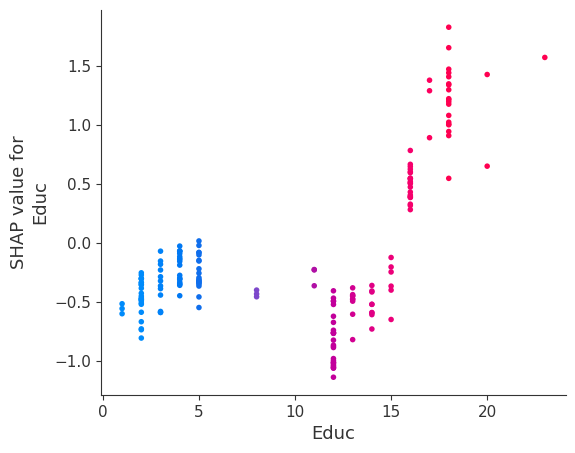

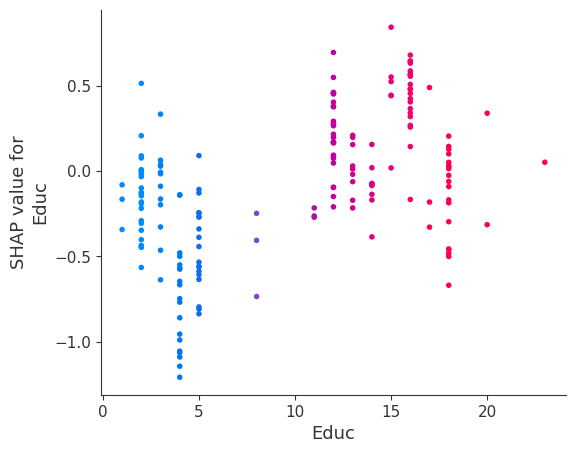

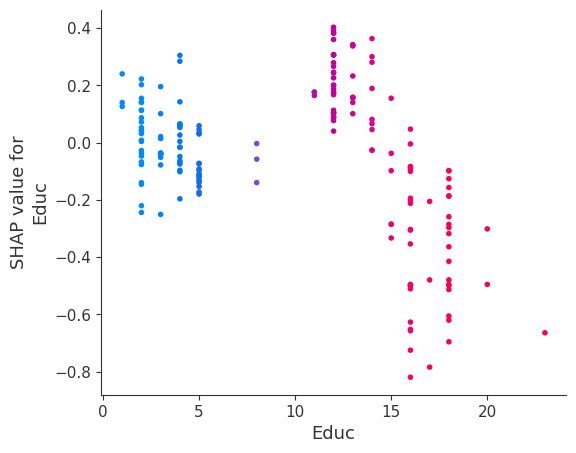

In [ ]:
for i in range(len(shap_values)):
  shap.dependence_plot('Educ', shap_values[i], X_test_shap, interaction_index='Educ')

In [ ]:
X_test_shap.shape

(180, 13)

In [ ]:
y_test_shap = y_test.values

Next we can see plots which show how much each feature in your data contributes to pushing the model output away from the expected value for a particular class.

In the context of SHAP force plots, the base value is the value at which the arrow starts. The features either push the prediction to the right (increase the prediction for the class) or to the left (decrease the prediction for the class), starting from the base value.

When we start create SHAP force plots for all classes, we can see how much each feature in your data contributes to pushing the model output away from the expected value for each class.

In [ ]:
from IPython.display import display

shap.initjs()
index = 4
print("Actual Dementia result : ", y_test_shap[index])
print("Predicted Dementia result : ", y_pred[index])
arr = [0,1,2]
for class_index in range(len(arr)):
  display(shap.force_plot(explainer.expected_value[class_index], shap_values[class_index][index], X_test_shap.iloc[index]))

Actual Dementia result :  0
Predicted Dementia result :  0


In [ ]:
from IPython.display import display

shap.initjs()
index = 2
print("Actual Dementia result : ", y_test_shap[index])
print("Predicted Dementia result : ", y_pred[index])
arr = [0,1,2]
for class_index in range(len(arr)):
  display(shap.force_plot(explainer.expected_value[class_index], shap_values[class_index][index], X_test_shap.iloc[index]))

Actual Dementia result :  1
Predicted Dementia result :  1


In [ ]:
from IPython.display import display

shap.initjs()
index = 100
print("Actual Dementia result : ", y_test_shap[index])
print("Predicted Dementia result : ", y_pred[index])
arr = [0,1,2]
for class_index in range(len(arr)):
  display(shap.force_plot(explainer.expected_value[class_index], shap_values[class_index][index], X_test_shap.iloc[index]))

NameError: ignored

For instance where index = 100, we can see the following results:

SHAP force plot for class 0: This plot here shows how each feature is contributing to the prediction for class 0. The contributions here are pushing the prediction away from class 0 towards the negative direction and so not predicting class 0.

SHAP force plot for class 1 (y_pred): This plot will show how each feature is contributing to the prediction for class 1. The strong positive contributions here are showing how the model predicts this class as the final outcome for dementia ( CDR ). The prediction here is wrong but the features in our dataset force the model towards the positive direction for class 1 and therefore predict this class finally. 

SHAP force plot for class 2 (y_true): This plot will show how each feature is contributing to the prediction for class 2. The contributions here from different features are pushing the shap values towards the positive direction but not more than that of class 1 and therefore we get the wrong output. 

In [ ]:
from IPython.display import display

shap.initjs()
index = 20
print("Actual Dementia result : ", y_test_shap[index])
print("Predicted Dementia result : ", y_pred[index])
arr = [0,1,2]
for class_index in range(len(arr)):
  display(shap.force_plot(explainer.expected_value[class_index], shap_values[class_index][index], X_test_shap.iloc[index]))

Actual Dementia result :  1
Predicted Dementia result :  1


#LIME ANALYSIS

In [ ]:
!pip install lime

In [ ]:
%matplotlib inline

from IPython.display import Markdown, display
import warnings
import lime
import lime.lime_tabular as lime_tabular
from lime import submodular_pick
import xgboost
from xgboost import plot_importance
import json
from collections import OrderedDict

In [ ]:
import lime
import lime.lime_tabular